# Policy Matching Tool: 10,000 AWS URLS example
## Matching Policies to Online Documentation

#### Neel Datta
#### August 2021

This tool helps narrow down the specific page of text within a Cyber Asset's Documentation (such as the documentation for an AWS or Azure service) that matches in meaning to the inputted search query, narrowing down the top N subpages from documentations which are often hundreds of pages long.

It makes use of the TF-IDF (term frequency-inverse document frequency) tool from NLTK in order to score and rank all the webpages in order of how similar they are to the inputted query/queries.

1. [Loading Modules/Functions](#sec1)  
2. [Generating XML Sheets to Feed Matching Tool](#sec2)  
3. [Example of Usage](#sec3)  

<a id="sec1"></a>
## Loading in required modules and ranking functions:


In [2]:
import json
import docsim
import re
import csv
import nltk
nltk.download('wordnet')
from urllib.request import urlopen
from urllib.error import HTTPError
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from tfidf import rank_documents
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/neeldatta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/neeldatta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# File creation tool: prompts user input to write in file with inputted name.
# If file name is taken, ask to overwrite, then overwrite.
def createFile(name = None):
    home = str(Path.home())
    directory = home + "/projects/docsim/"
    
    # get fileName from user
    if (name == None):
        filename = input("Enter filename: ")
    else:
        filename = name
            
    
    filepath = directory + filename
    # Creates a new file
    with open(filepath, 'w+') as fp:
        pass
    return filename

def createCSV(name = None):
    filename = createFile(name)
    with open(name, mode = 'w') as csvfile:
        csvdata = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csvdata.writerow(['Policy', 'Score', 'URL'])
    return filename

# Function that takes in xml file of a list of URLs and converts to string list where each string is a URL
def xmlToList(xml): 
    with open(xml, 'r') as f:
        temp = f.read()
    temp = re.findall("<loc>.*?</loc>", temp)
    strlist = []
    for s in temp:
        s = s[5:-6]
        strlist.append(s)
    return strlist
    
# Function that converts list of urls into a title + Data nodes in JSON, returns JSON file name
def htmlToJSON(htmlIn):
    data = {}
    data['data'] = []
    for url in htmlIn:
        while True:
            try:
                dpoint = [url]
                page = urlopen(url)
                html = page.read().decode("ISO-8859-1")
                soup = BeautifulSoup(html)
                dpoint.append(soup.get_text())
                data['data'].append(dpoint)
                break
            except HTTPError:
                print ("HTTPError at url: " + url)
                break
    JSONout = createFile()
    with open(JSONout, 'w') as outfile:
        json.dump(data, outfile)
    return JSONout

# Function that converts the list of controls/policies from a JupiterOne PDF into a list of strings
def JSONToList(JSONin):
    policies = pd.read_json(JSONin)
    plist = []
    for sec in policies['sections']:
        for req in sec['requirements']:
            plist.append(sec['title'] + ' ' + req['ref'] + ' : ' + req['title'] + ' : ' + req['summary'])
    return plist

## Function that takes in list of queries and returns top 5 URLs for each. Writes results into csv.

## Input: queries - a string list of search queries 
## urls: string of local file name for XML sheet saved form xml-sitemaps
## CSVOut: csv file to output all the ranking into
def runSearch(queries, urls, CSVOut):
    docs = 'Sec.JSON'

    with open(docs) as in_file:
        urldata = json.load(in_file)
    titles = [item[0] for item in urldata['data']]
    documents = [item[1] for item in urldata['data']]
    print(f'{len(documents)} documents')
    
    # Test on each query + Output findings into CSV file:
    with open(CSVOut, mode = 'a') as csvfile:
        csvdata = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for q in queries:
            document_scores = rank_documents(q, documents)
            score_titles = [(score, title) for score, title in zip(document_scores, titles)]
            print("Scores for query:\n" + q)
            for score, title in (sorted(score_titles, reverse=True, key=lambda x: x[0])[:5]):
                print(f'{score:0.3f} \t {title}')
                csvdata.writerow([q, str(score), title])               
    return



# Enter ALL data into csv
def runAllSearch(queries, CSVOut):
    docs = str(Path.home()) + "/SunstoneFiles/AWS10k.json"

    with open(docs) as in_file:
        urldata = json.load(in_file)
    titles = [item[0] for item in urldata['data']]
    documents = [item[1] for item in urldata['data']]
    print(f'{len(documents)} documents')
    
    # Test on each query + Output findings into CSV file:
    with open(CSVOut, mode = 'a') as csvfile:
        csvdata = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for q in queries:
            document_scores = rank_documents(q, documents)
            score_titles = [(score, title) for score, title in zip(document_scores, titles)]
            print("Scores for query:\n" + q)
            for score, title in (sorted(score_titles, reverse=True, key=lambda x: x[0])):
                csvdata.writerow([q, str(score), title])               
    return

<a id="sec2"></a>
## Generating XML sheet of URLs:

I've been using https://www.xml-sitemaps.com/ to generate my URL list to run my queries against.

For example, with AWS IAM, I ran the following:

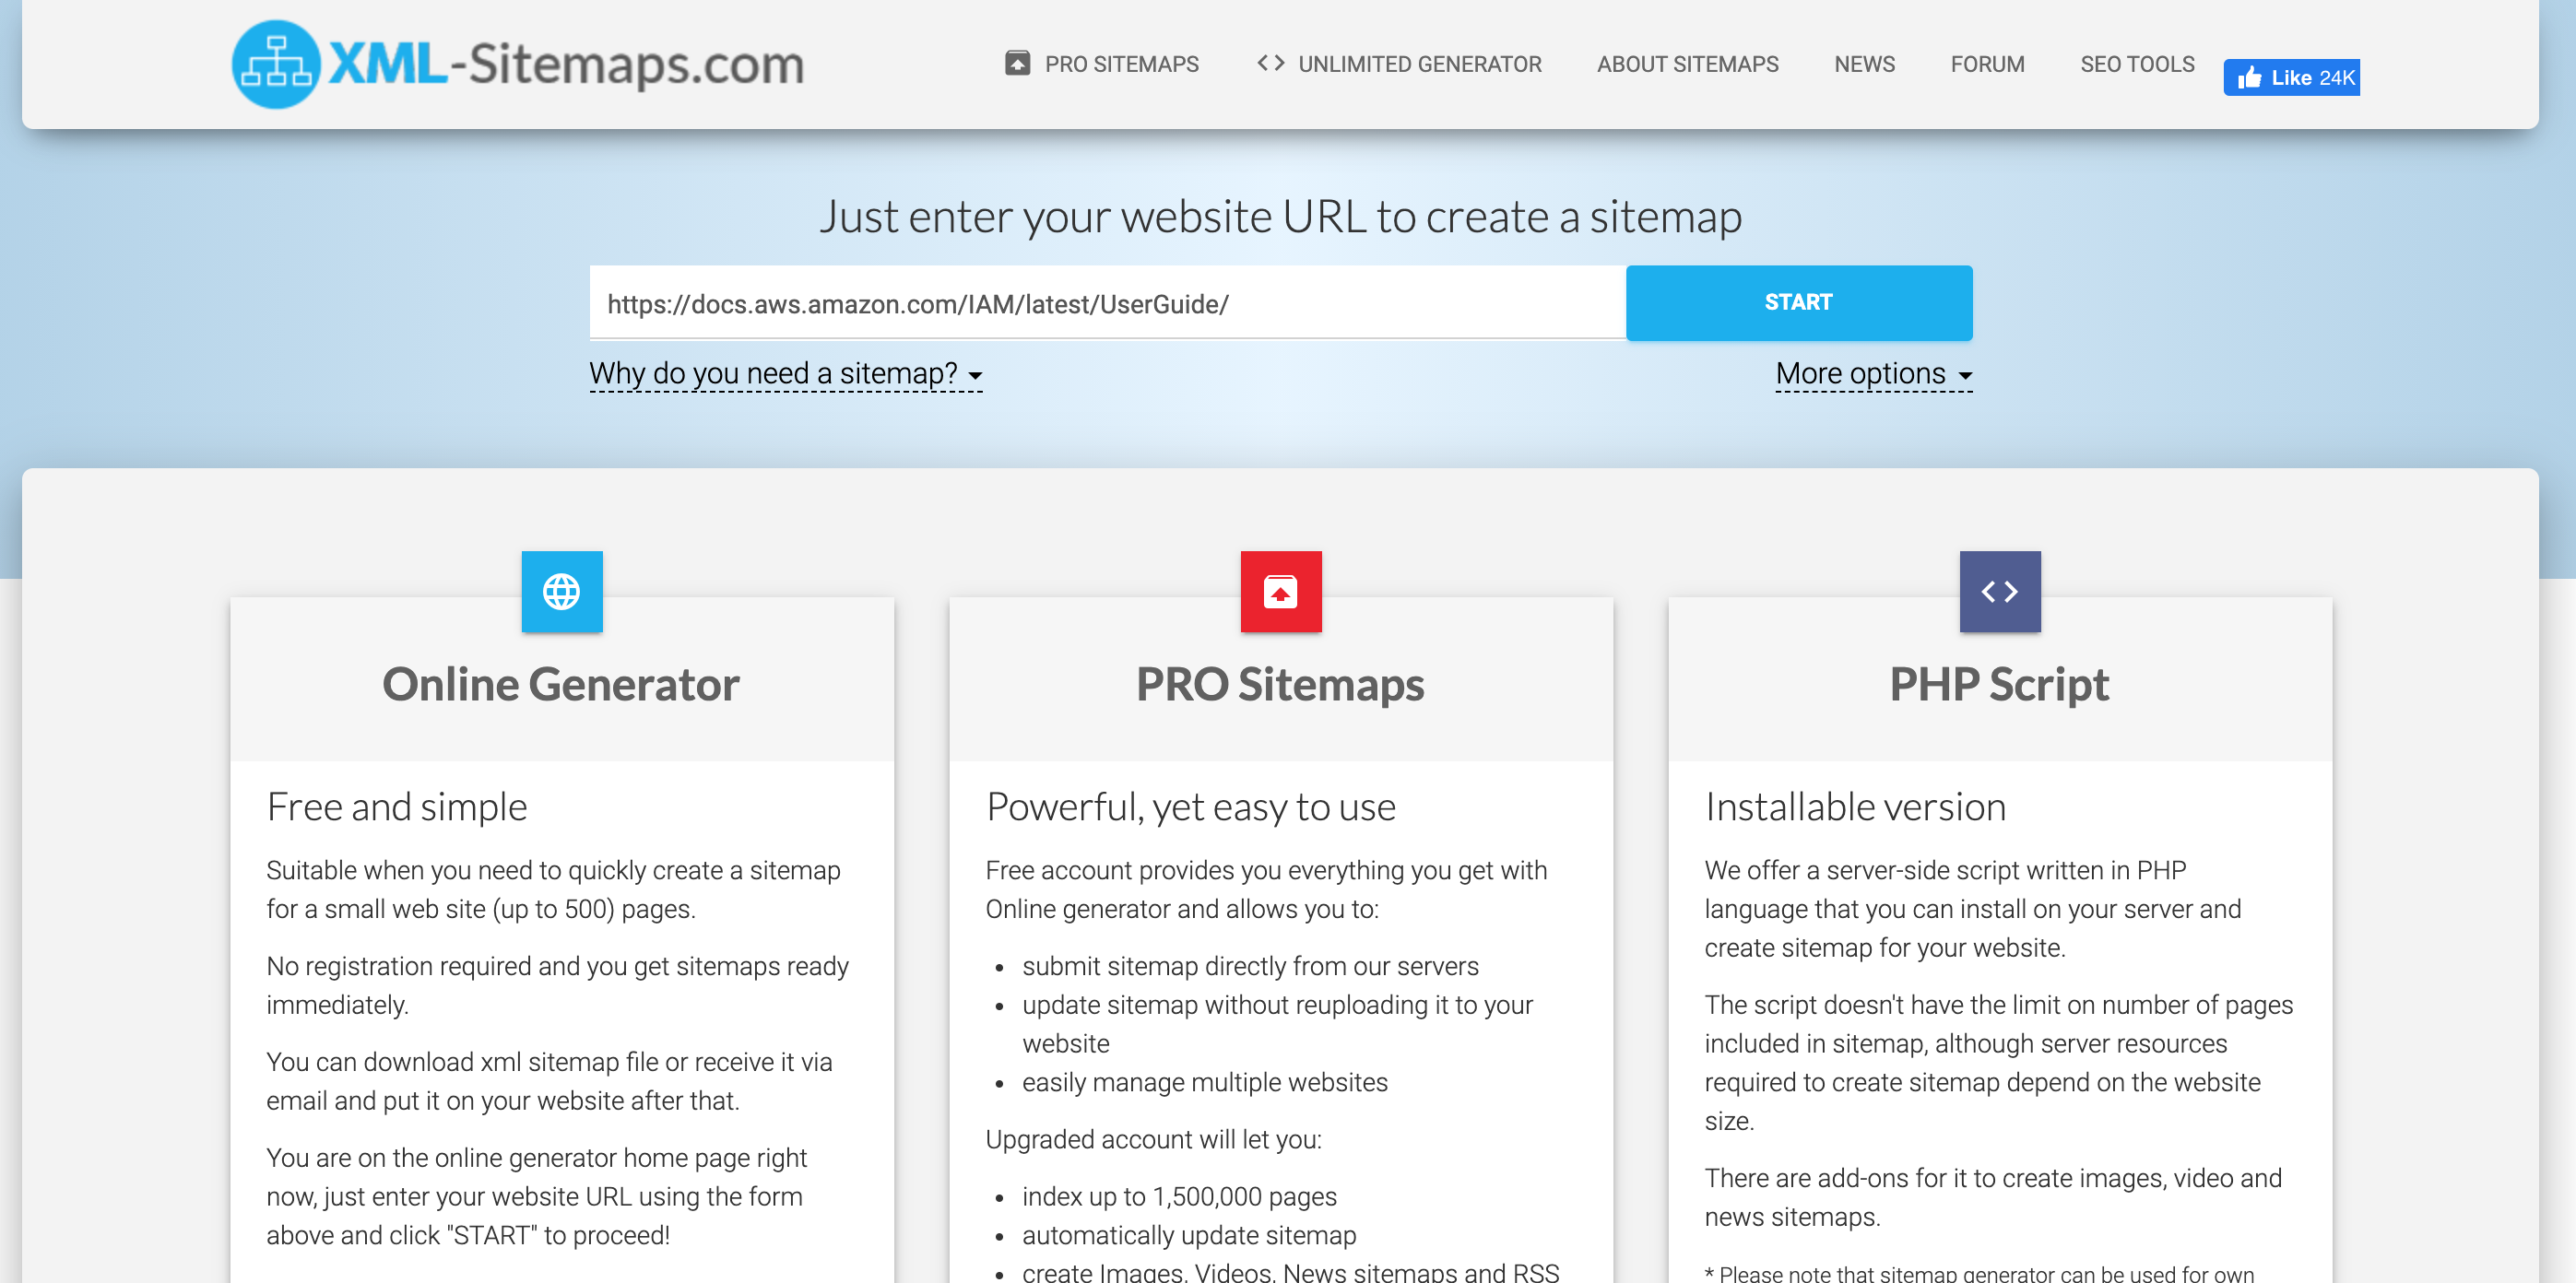

Which then returned the following XML file that I saved to this project folder, and converted to string list using the functions implemented above: 

In [19]:
%%time
exampleXML = "AWS.xml"
urls = xmlToList(exampleXML)
# Check first URL:
urls[0]

CPU times: user 21.6 ms, sys: 2.81 ms, total: 24.4 ms
Wall time: 22.8 ms


'https://docs.aws.amazon.com/'

In [20]:
%%time
query = ['Access Control. Access to program source code shall be restricted.']
csvExample = createCSV("testAppend.csv")


runSearch(query, 'SecurityHub.xml', csvExample)
runSearch(query, 'SecurityHub.xml', csvExample)

68 documents
Scores for query:
Access Control. Access to program source code shall be restricted.
0.111 	 https://docs.aws.amazon.com/securityhub/latest/userguide/securityhub-pci-controls.html
0.094 	 https://docs.aws.amazon.com/securityhub/latest/userguide/securityhub-standards-control-details.html
0.091 	 https://docs.aws.amazon.com/securityhub/latest/userguide/controls-view-manage.html
0.083 	 https://docs.aws.amazon.com/securityhub/latest/userguide/securityhub-standards-enable-disable-controls.html
0.082 	 https://docs.aws.amazon.com/securityhub/latest/userguide/securityhub-standards-fsbp-controls.html
68 documents
Scores for query:
Access Control. Access to program source code shall be restricted.
0.111 	 https://docs.aws.amazon.com/securityhub/latest/userguide/securityhub-pci-controls.html
0.094 	 https://docs.aws.amazon.com/securityhub/latest/userguide/securityhub-standards-control-details.html
0.091 	 https://docs.aws.amazon.com/securityhub/latest/userguide/controls-view-manage

In [43]:
df = pd.read_csv("testAppend.csv")
df

,Policy,Score,URL
0,Access Control. Access to program source code ...,0.110515,https://docs.aws.amazon.com/securityhub/latest...
1,Access Control. Access to program source code ...,0.093930,https://docs.aws.amazon.com/securityhub/latest...
2,Access Control. Access to program source code ...,0.091069,https://docs.aws.amazon.com/securityhub/latest...
3,Access Control. Access to program source code ...,0.082720,https://docs.aws.amazon.com/securityhub/latest...
4,Access Control. Access to program source code ...,0.082492,https://docs.aws.amazon.com/securityhub/latest...
5,Access Control. Access to program source code ...,0.110515,https://docs.aws.amazon.com/securityhub/latest...
6,Access Control. Access to program source code ...,0.093930,https://docs.aws.amazon.com/securityhub/latest...
7,Access Control. Access to program source code ...,0.091069,https://docs.aws.amazon.com/securityhub/latest...
8,Access Control. Access to program source code ...,0.082720,https://docs.aws.amazon.com/securityhub/latest...
9,Access Control. Access to program source code ...,0.082492,https://docs.aws.amazon.com/securityhub/latest...


<a id="sec3"></a>
## Running tool on 10 random queries from Assesment Test Queries:

In [15]:
queries = ['Automated mechanisms implementing cross-organizational auditing (if applicable)',
 'Automated mechanisms implementing information flow enforcement policy',
 'Automated mechanisms supporting and/or implementing loading and executing the operating environment from hardware-enforced, read-only media',
 'Automated mechanisms supporting and/or implementing mobile code detection, inspection, and corrective capability',
 'Organizational processes for protecting nonlocal maintenance sessions',
 'Automated mechanisms implementing techniques or technologies associating security attributes to information',
 'Automated mechanisms supporting and/or implementing multifactor authentication capability',
 'Organizational processes for designing the information security architecture',
 'Automated mechanisms implementing least privilege functions',
 'Organizational processes for vulnerability analysis of information systems, system components, or information system services under development']

In [17]:
f5 = queries[:5]
l5 = queries[5:]

In [21]:
%%time 
tenAssess = createCSV("tenAssess.csv")
runAllSearch(f5, tenAssess)

10000 documents
Scores for query:
Automated mechanisms implementing cross-organizational auditing (if applicable)
Scores for query:
Automated mechanisms implementing information flow enforcement policy
Scores for query:
Automated mechanisms supporting and/or implementing loading and executing the operating environment from hardware-enforced, read-only media
Scores for query:
Automated mechanisms supporting and/or implementing mobile code detection, inspection, and corrective capability
Scores for query:
Organizational processes for protecting nonlocal maintenance sessions
CPU times: user 2h 30min 18s, sys: 1min 58s, total: 2h 32min 16s
Wall time: 2h 32min 40s


In [22]:
%%time
runAllSearch(l5, tenAssess)

10000 documents
Scores for query:
Automated mechanisms implementing techniques or technologies associating security attributes to information
Scores for query:
Automated mechanisms supporting and/or implementing multifactor authentication capability
Scores for query:
Organizational processes for designing the information security architecture
Scores for query:
Automated mechanisms implementing least privilege functions
Scores for query:
Organizational processes for vulnerability analysis of information systems, system components, or information system services under development
CPU times: user 2h 25min 43s, sys: 1min 36s, total: 2h 27min 19s
Wall time: 2h 27min 32s


In [23]:
df = pd.read_csv('tenAssess.csv')
df

,Policy,Score,URL
0,Automated mechanisms implementing cross-organi...,0.121341,https://docs.aws.amazon.com/sagemaker/latest/d...
1,Automated mechanisms implementing cross-organi...,0.073807,https://docs.aws.amazon.com/sdk-for-ruby/v2/ap...
2,Automated mechanisms implementing cross-organi...,0.072155,https://docs.aws.amazon.com/sdk-for-ruby/v2/ap...
3,Automated mechanisms implementing cross-organi...,0.063515,https://docs.aws.amazon.com/sdk-for-ruby/v2/ap...
4,Automated mechanisms implementing cross-organi...,0.062759,https://docs.aws.amazon.com/govcloud-us/latest...
...,...,...,...
99995,Organizational processes for vulnerability ana...,0.000000,https://docs.aws.amazon.com/sdk-for-ruby/v2/ap...
99996,Organizational processes for vulnerability ana...,0.000000,https://docs.aws.amazon.com/sdk-for-ruby/v2/ap...
99997,Organizational processes for vulnerability ana...,0.000000,https://docs.aws.amazon.com/sdk-for-ruby/v2/ap...
99998,Organizational processes for vulnerability ana...,0.000000,https://docs.aws.amazon.com/sdk-for-ruby/v2/ap...


In [62]:
## This is the code we ran to append the top 5 results of each random query from my list of 100,000 data points to Dimitar's data.

#with open('firstTenQueries(top5).csv', 'a') as f2:
    #arr = []
    #counter = 0;
    #with open("tenAssess.csv", "r") as file:
        #for line in file:
            #if counter < 6 and counter > 0:
                #f2.write('\n')
                #f2.write(line)
            #counter = counter + 1
            #if counter == 10000:
                #counter = 0

In [14]:
df = pd.read_csv('firstTenQueries(top5).csv')
df = df[~df['URL'].str.contains('ruby')]
df

,Policy,Score,URL
0,Organizational processes for intrusion detecti...,0.061358,https://docs.aws.amazon.com/securityhub/latest...
1,Organizational processes for intrusion detecti...,0.041739,https://docs.aws.amazon.com/securityhub/latest...
2,Organizational processes for intrusion detecti...,0.040100,https://docs.aws.amazon.com/securityhub/latest...
3,Organizational processes for intrusion detecti...,0.033835,https://docs.aws.amazon.com/securityhub/latest...
4,Organizational processes for intrusion detecti...,0.030992,https://docs.aws.amazon.com/securityhub/latest...
...,...,...,...
91,Automated mechanisms implementing least privil...,0.174095,https://docs.aws.amazon.com/step-functions/lat...
95,Organizational processes for vulnerability ana...,0.436105,https://docs.aws.amazon.com/systems-manager/la...
96,Organizational processes for vulnerability ana...,0.428347,https://docs.aws.amazon.com/systems-manager/la...
97,Organizational processes for vulnerability ana...,0.337717,https://docs.aws.amazon.com/systems-manager/la...


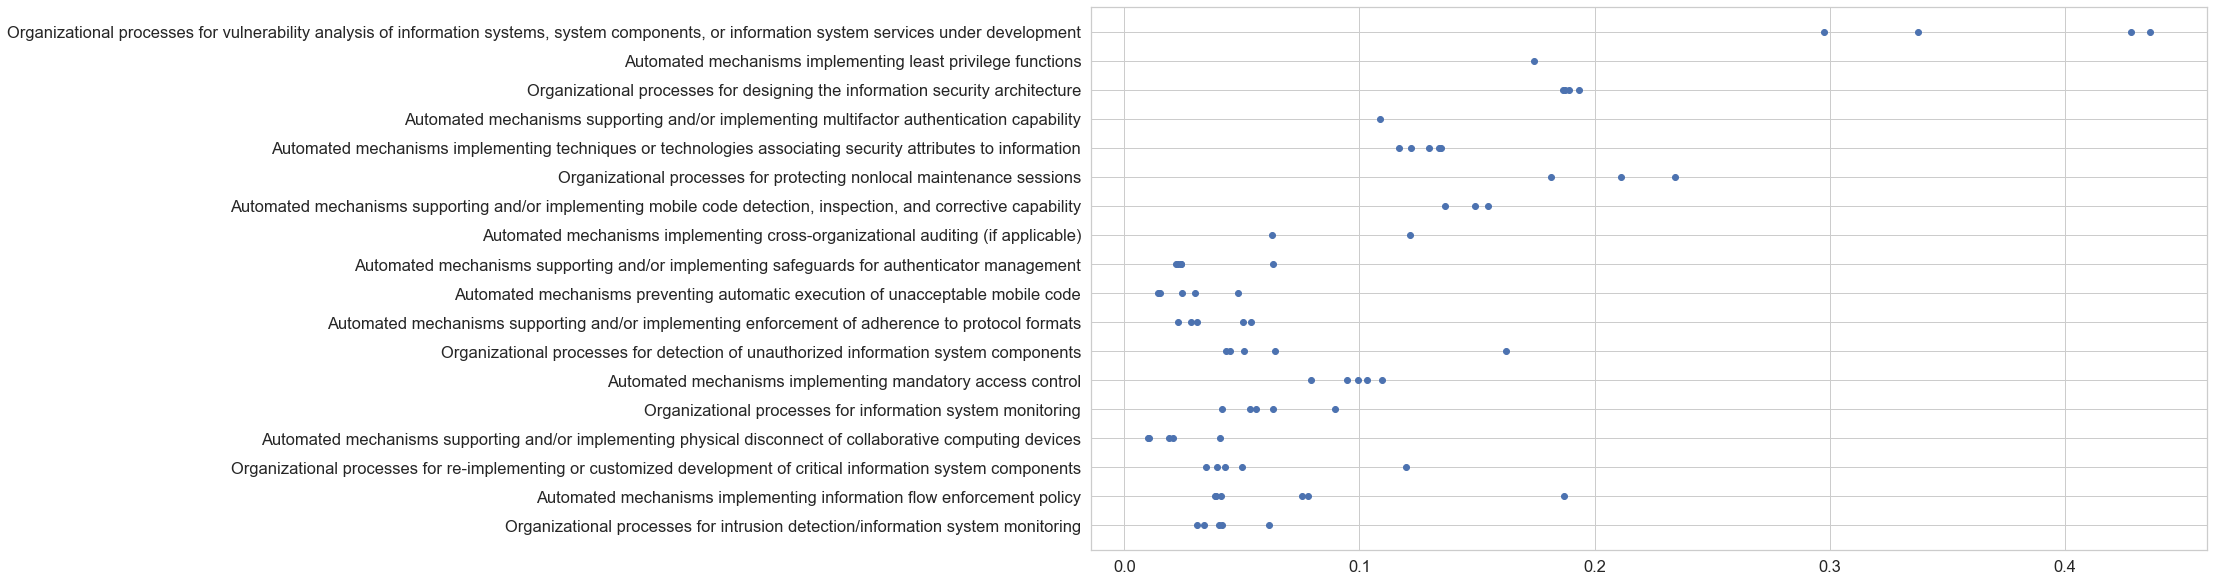

In [10]:
# Create Scatterplot with scores as X axis and Policies as Y axis

import numpy as np
import matplotlib.pyplot as plt
 
plt.figure(figsize=(20,10))

x = df["Score"]
y = df["Policy"]

plt.scatter(x, y)

plt.show()

In [87]:
x = df.to_string(header=False,
                  index=False,
                  index_names=False).split('\n')
vals = [', '.join(ele.split()) for ele in x] 
for v in vals:
    print(v)

Organizational, processes, for, intrusion, detection/information, system, monitoring, 0.061358, https://docs.aws.amazon.com/securityhub/latest/userguide/securityhub-pci-controls.html
Organizational, processes, for, intrusion, detection/information, system, monitoring, 0.041739, https://docs.aws.amazon.com/securityhub/latest/userguide/standards-fsbp-config-resources.html
Organizational, processes, for, intrusion, detection/information, system, monitoring, 0.040100, https://docs.aws.amazon.com/securityhub/latest/userguide/securityhub-benefits.html
Organizational, processes, for, intrusion, detection/information, system, monitoring, 0.033835, https://docs.aws.amazon.com/securityhub/latest/userguide/securityhub-internal-providers.html
Organizational, processes, for, intrusion, detection/information, system, monitoring, 0.030992, https://docs.aws.amazon.com/securityhub/latest/userguide/control-categories.html
Automated, mechanisms, implementing, information, flow, enforcement, policy, 0.078

# Full dataframe of all 20 queries x 10,000 links = 200,000 data points:

In [1]:
## This is the code we ran to append the results of each random query from my list of 100,000 data points to Dimitar's data.
#with open('firstTenQueries(all).csv', 'a') as f2:
 #   arr = []
  #  counter = 0;
   # with open("tenAssess.csv", "r") as file:
    #    for line in file:
     #       f2.write('\n')
      #      f2.write(line)

In [9]:
df = pd.read_csv('firstTenQueries(all).csv')
df

,Policy,Score,URL
0,Organizational processes for intrusion detecti...,0.16380278818311086,https://docs.aws.amazon.com/systems-manager/la...
1,Organizational processes for intrusion detecti...,0.16072703014605996,https://docs.aws.amazon.com/systems-manager/la...
2,Organizational processes for intrusion detecti...,0.12646645263635523,https://docs.aws.amazon.com/systems-manager/la...
3,Organizational processes for intrusion detecti...,0.12289212676514888,https://docs.aws.amazon.com/cli/latest/referen...
4,Organizational processes for intrusion detecti...,0.12024376356880076,https://docs.aws.amazon.com/data-exchange/late...
...,...,...,...
199996,Organizational processes for vulnerability ana...,0.0,https://docs.aws.amazon.com/sdk-for-ruby/v2/ap...
199997,Organizational processes for vulnerability ana...,0.0,https://docs.aws.amazon.com/sdk-for-ruby/v2/ap...
199998,Organizational processes for vulnerability ana...,0.0,https://docs.aws.amazon.com/sdk-for-ruby/v2/ap...
199999,Organizational processes for vulnerability ana...,0.0,https://docs.aws.amazon.com/sdk-for-ruby/v2/ap...


In [12]:
# Create Scatterplot with scores as X axis and Policies as Y axis

import numpy as np
import matplotlib.pyplot as plt
 
plt.figure(figsize=(30,20))

x = df["Score"]
y = df["Policy"]

plt.xticks(np.arange(min(x), max(x)+1, 0.025))

plt.scatter(x, y)

plt.show()

TypeError: can only concatenate str (not "int") to str

<Figure size 2160x1440 with 0 Axes>

In [ ]:
df = 